In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import cv2
import sys
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Reshape, Dropout, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.models import Model
from keras.layers import Dropout

In [3]:
# Data Cleaning and preprocessing
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import random
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Data Loading

In [4]:
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [5]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [6]:
# Read data from JSON file
with open('/content/drive/MyDrive/Q3/data_full.json') as json_file: 
    data_dict = json.load(json_file) 


In [7]:
# Load data into respective dicts
train_data = data_dict['train']
val_data = data_dict['val']
test_data = data_dict['test']

In [8]:
from pandas import DataFrame
train = DataFrame(train_data, columns = ['Query','Intent'])
test = DataFrame(test_data, columns=['Query','Intent'])
val = DataFrame(val_data, columns=['Query','Intent'])


In [9]:
# Selected 20 output intents
intent_small = ["balance", "pin_change","credit_score", "rewards_balance","calories",
                "restaurant_reviews", "shopping_list", "next_song", "traffic","uber",
                "translate", "vaccines","alarm", "date", "taxes", 
                "insurance", "greeting", "fun_fact","cancel", "yes"]

In [10]:
# Filter dataframes with selected 20 intents
train_df_small = train[train['Intent'].isin(intent_small)]
val_df_small = val[val['Intent'].isin(intent_small)]
test_df_small = test[test['Intent'].isin(intent_small)]
print("Total Samples-: Train: {0}, Validation: {1}, Test: {2}".format(len(train_df_small),len(val_df_small),len(test_df_small)))

# Append all sets together for ease of vectorization in further steps. Although, individual dataframes can be used as well.
entire_small_df = train_df_small.append(val_df_small).append(test_df_small)
print("Total Samples combined: ",len(entire_small_df))

Total Samples-: Train: 2000, Validation: 400, Test: 600
Total Samples combined:  3000


In [ ]:
train.head(5)

,Query,Intent
0,can you walk me through setting up direct depo...,direct_deposit
1,i want to switch to direct deposit,direct_deposit
2,set up direct deposit for me,direct_deposit
3,how do i go about setting up direct deposit,direct_deposit
4,i need to get my paycheck direct deposited to ...,direct_deposit


In [ ]:
test.head(5)

,Query,Intent
0,how would you say fly in italian,translate
1,what's the spanish word for pasta,translate
2,how would they say butter in zambia,translate
3,how do you say fast in spanish,translate
4,what's the word for trees in norway,translate


In [11]:
# Show label unique
print(np.unique(train["Intent"]))
total_label = int(len(np.unique(train["Intent"])))
print("\n ====>   Total: ", total_label)

['accept_reservations' 'account_blocked' 'alarm' 'application_status'
 'apr' 'are_you_a_bot' 'balance' 'bill_balance' 'bill_due' 'book_flight'
 'book_hotel' 'calculator' 'calendar' 'calendar_update' 'calories'
 'cancel' 'cancel_reservation' 'car_rental' 'card_declined' 'carry_on'
 'change_accent' 'change_ai_name' 'change_language' 'change_speed'
 'change_user_name' 'change_volume' 'confirm_reservation' 'cook_time'
 'credit_limit' 'credit_limit_change' 'credit_score' 'current_location'
 'damaged_card' 'date' 'definition' 'direct_deposit' 'directions'
 'distance' 'do_you_have_pets' 'exchange_rate' 'expiration_date'
 'find_phone' 'flight_status' 'flip_coin' 'food_last' 'freeze_account'
 'fun_fact' 'gas' 'gas_type' 'goodbye' 'greeting' 'how_busy'
 'how_old_are_you' 'improve_credit_score' 'income'
 'ingredient_substitution' 'ingredients_list' 'insurance'
 'insurance_change' 'interest_rate' 'international_fees'
 'international_visa' 'jump_start' 'last_maintenance' 'lost_luggage'
 'make_call'

In [12]:
# Check balance data
train['Intent'].value_counts()[:20]

translate                 100
order_status              100
goodbye                   100
account_blocked           100
what_song                 100
international_fees        100
last_maintenance          100
meeting_schedule          100
ingredients_list          100
report_fraud              100
measurement_conversion    100
smart_home                100
book_hotel                100
current_location          100
weather                   100
taxes                     100
min_payment               100
pin_change                100
accept_reservations       100
cancel                    100
Name: Intent, dtype: int64

In [13]:
# Get sentences into list
entire_sents = list(entire_small_df["Query"])
entire_intents = list(entire_small_df["Intent"])

In [14]:
# Prepare Labels and for every sample, assign an unique category id to each intent in a new column in dataframe.
entire_small_df['category_id'] = entire_small_df['Intent'].factorize()[0]
category_id_df = entire_small_df[['Intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Intent']].values)
labels = entire_small_df.category_id

# Data Cleaning

In [15]:
def cleaning(sents):
    words = []
    lemmatizer = WordNetLemmatizer()
    for sent in sents:
        # Remove anything that is not alphanumeric character
        cleaned_sent = re.sub(r'[^ a-z A-Z 0-9]', " ", sent)
        # Split sentence into chunks of words i.e. tokens
        word = nltk.tokenize.word_tokenize(cleaned_sent)
        # Lemmatize the tokens i.e. convert it to its dictionary form
        words.append([lemmatizer.lemmatize(w.lower()) for w in word])
        
    return words

In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
cleaned_entire_sents = cleaning(entire_sents)
print(cleaned_entire_sents[10:15])

[['how', 'would', 'i', 'say', 'i', 'don', 't', 'know', 'the', 'answer', 'in', 'spanish'], ['i', 'would', 'like', 'to', 'know', 'the', 'proper', 'way', 'to', 'greet', 'an', 'adult', 'in', 'portuguese'], ['what', 'word', 'would', 'i', 'use', 'to', 'tell', 'someone', 'i', 'am', 'lost', 'if', 'i', 'were', 'japanese'], ['how', 'would', 'i', 'say', 'thank', 'you', 'if', 'i', 'were', 'russian'], ['can', 'you', 'tell', 'me', 'how', 'i', 'would', 'normally', 'say', 'thank', 'you', 'a', 'a', 'french', 'person']]


# Feature Selection and Vectorization

In [23]:
def temp_tokenizer(text):
    return text

In [24]:
# Feature size is limited to 8000 which is large enough to include all the important N-grams
# A dummy tokenizer is passed to include a list of lists inside the vectorizer
tfidf = TfidfVectorizer(max_features=8000, lowercase=False, tokenizer=temp_tokenizer, ngram_range=(1,2))
X_entire = tfidf.fit_transform(cleaned_entire_sents).toarray()

In [25]:
# Validating N-Grams to see the features representing the intent classes
N = 2 # 3
for classs, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(X_entire, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(classs))
    print("  - Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  - Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    #print("  - Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'alarm':
  - Most correlated unigrams:
. set
. alarm
  - Most correlated bigrams:
. alarm for
. an alarm
# 'balance':
  - Most correlated unigrams:
. balance
. bank
  - Most correlated bigrams:
. in my
. my bank
# 'calories':
  - Most correlated unigrams:
. many
. calorie
  - Most correlated bigrams:
. calorie are
. many calorie


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'cancel':
  - Most correlated unigrams:
. cancel
. stop
  - Most correlated bigrams:
. stop talking
. cancel that
# 'credit_score':
  - Most correlated unigrams:
. score
. credit
  - Most correlated bigrams:
. credit score
. my credit
# 'date':
  - Most correlated unigrams:
. day
. date
  - Most correlated bigrams:
. s date
. the date


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'fun_fact':
  - Most correlated unigrams:
. fact
. about
  - Most correlated bigrams:
. fun fact
. fact about
# 'greeting':
  - Most correlated unigrams:
. hi
. hey
  - Most correlated bigrams:
. how are
. are you
# 'insurance':
  - Most correlated unigrams:
. benefit
. insurance
  - Most correlated bigrams:
. my insurance
. my health


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'next_song':
  - Most correlated unigrams:
. next
. song
  - Most correlated bigrams:
. next song
. the next
# 'pin_change':
  - Most correlated unigrams:
. change
. pin
  - Most correlated bigrams:
. my pin
. pin number


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'restaurant_reviews':
  - Most correlated unigrams:
. good
. review
  - Most correlated bigrams:
. are the
. the review
# 'rewards_balance':
  - Most correlated unigrams:
. card
. reward
  - Most correlated bigrams:
. my reward
. reward balance


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'shopping_list':
  - Most correlated unigrams:
. list
. shopping
  - Most correlated bigrams:
. my shopping
. shopping list


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'taxes':
  - Most correlated unigrams:
. pay
. tax
  - Most correlated bigrams:
. pay in
. state tax
# 'traffic':
  - Most correlated unigrams:
. way
. traffic
  - Most correlated bigrams:
. way to
. the traffic
# 'translate':
  - Most correlated unigrams:
. spanish
. say
  - Most correlated bigrams:
. in spanish
. i say


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'uber':
  - Most correlated unigrams:
. an
. uber
  - Most correlated bigrams:
. uber to
. an uber
# 'vaccines':
  - Most correlated unigrams:
. before
. shot
  - Most correlated bigrams:
. before i
. travel to


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'yes':
  - Most correlated unigrams:
. true
. yes
  - Most correlated bigrams:
. that is
. that s


# Data Split

In [26]:
# First 2000 rows corresponds to training data
X_train = X_entire[:2000]
y_train = entire_intents[:2000]

# Rows 2400 to 3000 corresponds to Testing data
X_test = X_entire[2400:]
y_test = entire_intents[2400:]

# Classifier Model Preparation

In [27]:
mlp_classifier = MLPClassifier()

clf_dict = {"MultilayerPercpClassifier":mlp_classifier}

In [28]:
def fit_classifier(label, clf, X_train, y_train):
    print('======================================================')
    print("Training Classifier : ", label)
    return clf.fit(X_train, y_train)

In [29]:
def evaluate_classifier(label, clf, X_test, y_test):
    print('======================================================')
    print("Testing Classifier: ", label)
    
    y_pred = clf.predict(X_test)
    #classification_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision,recall,fscore,support=precision_recall_fscore_support(y_test,y_pred,average='macro')
    print('\nClassification Metrics:')
    print('Precision : {}'.format(precision))
    print('Recall    : {}'.format(recall))
    print('F-score   : {}'.format(fscore))
    print('Accuracy  : {}'.format(accuracy))
    print('======================================================')

In [30]:
def train_and_evaluate_clf(clf_dict, X_train, y_train, X_test, y_test):
    
    print("Training and Evaluating all the models:")
    
    for label, clf in clf_dict.items():
        
        trained_classifier = fit_classifier(label, clf, X_train, y_train)
        print('======================================================')
        
        evaluate_classifier(label, trained_classifier, X_test, y_test)

In [31]:
train_and_evaluate_clf(clf_dict, X_train, y_train, X_test, y_test)

Training and Evaluating all the models:
Training Classifier :  MultilayerPercpClassifier
Testing Classifier:  MultilayerPercpClassifier

Classification Metrics:
Precision : 0.9740028112035816
Recall    : 0.9733333333333334
F-score   : 0.9731020215566876
Accuracy  : 0.9733333333333334


In [32]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


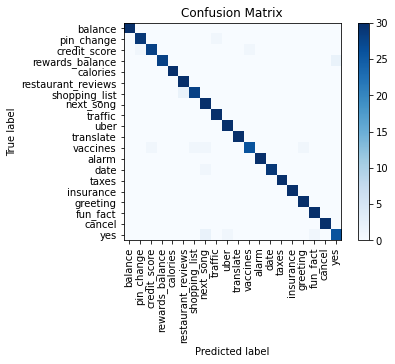

In [33]:
y_pred = mlp_classifier.predict(X_test)
matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm=matrix, normalize=True, classes=intent_small, title='Confusion Matrix')